In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import time 
import tensorflow as tf 
from tensorflow import keras

In [2]:
#查看tesorflow版本
print(tf.__version__)

2.3.1


### 一、切分数据

In [3]:
#导入fashion_mnist手写数字数据集
fashion_mnist=keras.datasets.fashion_mnist
#创建训练集和验证集
(x_train_all,y_train_all),(x_test,y_test)=fashion_mnist.load_data()
#将训练集进一步拆分成训练集和验证集合
#前5000张作为验证集，5000张之后都作为训练集
x_valid,x_train=x_train_all[:5000],x_train_all[5000:]
y_valid,y_train=y_train_all[:5000],y_train_all[5000:]

### 二、对数据做归一化

In [4]:
#归一化,归一化在深度学习中非常重要，可以有效的提高模型的准确率
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
#归一化需要是二维矩阵，而这里的x_train,x_valid都是三维的所以需要先reshape（-1,1）,之后再reshape回三维的
x_train_scaled=scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled=scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled=scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [5]:
#查看训练集合，测试集，验证集的数据形状
print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


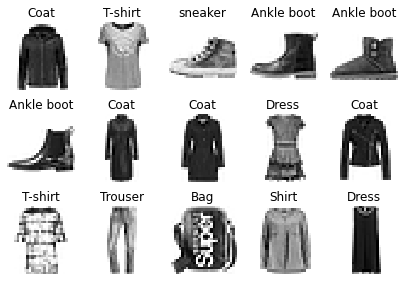

In [6]:
def show_imgs(n_rows,n_cols,x_data,y_data,class_name):
    assert len(x_data)==len(y_data)
    assert n_rows*n_cols<len(x_data)
    plt.figure(figsize=(n_cols*1.4,n_rows*1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index =n_cols*row+col
            plt.subplot(n_rows,n_cols,index+1)
            plt.imshow(x_data[index],cmap='binary',interpolation='nearest')
            plt.axis('off')
            plt.title(class_name[y_data[index]])
    plt.show()

class_name=['T-shirt','Trouser','pullover','Dress','Coat','Sandal','Shirt','sneaker','Bag','Ankle boot']
show_imgs(3,5,x_train,y_train,class_name)

### 三、模型构建

In [7]:
#tf.keras.models.sequential()
#实例化
model=keras.models.Sequential()
#添加输入层数据
model.add(keras.layers.Flatten(input_shape=[28,28]))
#添加全连接层
model.add(keras.layers.Dense(300,activation='relu'))
#再添加一层全连接层，这层要与上一层做连接
model.add(keras.layers.Dense(100,activation='relu'))
#添加输出层的层数，本次是一个10分类的问题，所以分成10份
model.add(keras.layers.Dense(10,activation='softmax'))

#定义激活函数
#relu:y=max(0,x),输入是x，输出是x和0两个数字中较大的一个
#softmax：将向量变成概率分布
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.SGD(0.001),metrics=['accuracy']) 

In [8]:
#查看神经网络有多少层神经网络
model.layers

In [9]:
#查看模型架构
model.summary()
#[None,784]*w+b->[None,300] w.shape [784,300],b=[300]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### 四、模型训练

In [15]:
#模型训练,添加callback回调函数(Tensorboard,earlystopping,ModelCheckpoint)
logdir='./callbacks' #创建一个文件路径以及文件名，模型跑出来的结果会保存在项目文件的callbacks中去
import os
if not os.path.exists(logdir):
    os.mkdir(logdir)

output_model_file=os.path.join(logdir,'fashion_mnist_model.h5')
#定义回调函数
callbacks=[
    #使用tensorboard
    keras.callbacks.TensorBoard(logdir),
    #每次跑完模型保存模型
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    #当指标在运行中没有提升，就提前停止训练
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)   #1e-3表示1的e负3次方
]
history=model.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)

Epoch 1/10
   1/1719 [..............................] - ETA: 0s - loss: 2.6014 - accuracy: 0.0938WARNING:tensorflow:From C:\Users\xiongyuan\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8748 - accuracy: 0.7164 - val_loss: 0.6082 - val_accuracy: 0.7980
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5694 - accuracy: 0.8025 - val_loss: 0.5214 - val_accuracy: 0.8242
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5080 - accuracy: 0.8225 - val_loss: 0.4831 - val_accuracy: 0.8370
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4741 - accuracy: 0.8334 - val_loss: 0.4576 - val_accuracy: 0.8470
Epoch 5/10
1719/1719 [==============================

In [16]:
history.history

{'loss': [0.8747745156288147,
  0.5694005489349365,
  0.5079589486122131,
  0.4740881323814392,
  0.45139187574386597,
  0.4339643120765686,
  0.4200272262096405,
  0.4088941812515259,
  0.398912250995636,
  0.3902381658554077],
 'accuracy': [0.7164182066917419,
  0.8024545311927795,
  0.8225454688072205,
  0.8334363698959351,
  0.8422909379005432,
  0.8474000096321106,
  0.852545440196991,
  0.8557636141777039,
  0.8593454360961914,
  0.8624181747436523],
 'val_loss': [0.6082213521003723,
  0.5214440822601318,
  0.48310360312461853,
  0.45763853192329407,
  0.4411832094192505,
  0.4288484454154968,
  0.42122334241867065,
  0.4110836386680603,
  0.4043051600456238,
  0.4008524715900421],
 'val_accuracy': [0.7979999780654907,
  0.8241999745368958,
  0.8370000123977661,
  0.847000002861023,
  0.8496000170707703,
  0.8515999913215637,
  0.8551999926567078,
  0.8592000007629395,
  0.8592000007629395,
  0.8629999756813049]}

### 五、查看模型效果

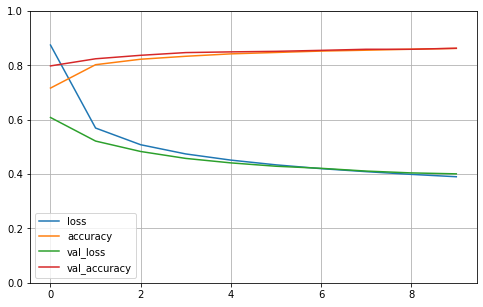

In [17]:
#绘图，也可以不绘图，直接用tensorboard打开查看结果
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)
#可以看出损失函数在不断的下降，准确率在不断的提升

In [18]:
#可以在测试集上进一步评估模型结果
model.evaluate(x_test_scaled,y_test)
#可以看到结果中测试集上loss是0.44,准确率是0.84

313/313 [==============================] - 0s 851us/step - loss: 0.4327 - accuracy: 0.8439


[0.43274903297424316, 0.8439000248908997]

### 五、读取callback的结果

In [23]:
#1--打开anaconda的powershell
#2--cd到项目文件夹中去
#3--输入命令：tensorboard --logdir=callbacks #注意callbacks是文件名，是自己之前回调函数中创建的